In [1]:
# Python Data ETL with Pandas libraires
# Learning about the performance difference between
# 1 - For Loop (Slowest)
# 2 - Apply Function (Standard)
# 3 - Multiprocessing Apply Function (Really Easy to do!)

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

from pandarallel import pandarallel

import math
import numpy as np

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

# How to turn on the progress bar
# https://stackoverflow.com/questions/45595689/how-to-fix-tqdm-progress-apply-for-pandas-in-jupyter/51085407

# How to configurate %%timeit -n(number)
# https://ipython.readthedocs.io/en/stable/interactive/magics.html

In [3]:
# Generate random input

def reset_df():
    global df
    # randint -- [lowbound, upbound)
    # randint(1, 2) -- [0, 2) 
    # this will generate 0 or 1, because 2 is not included

    # 100K rows
    df = pd.DataFrame(np.random.randint(0, 2, size=(1000000, 2)),
                      columns=["form_code", "ipop_ind"])

    # form_code: type of Medicaid Form
    # 0 = U (Institutional), 1 = H (Professional)

    # ipop_ind : inpatient or outpatient indicator
    # 0 = inpatient, 1 = outpatient

reset_df()
print(df.shape)
df.head()

(1000000, 2)


,form_code,ipop_ind
0,0,0
1,0,0
2,0,1
3,1,0
4,0,1


In [4]:
# method 1: simple
def update_simple(df):
    claim_type_list = []
    for index, row in df.iterrows():
        if row['form_code'] == 1:
            # Professional
            claim_type = 'P'
        elif row['ipop_ind'] == 0:
            # Institutional Inpatient
            claim_type = 'I'
        else:
            # Institutional Outpatient
            claim_type = 'O'
        claim_type_list.append(claim_type)

In [5]:
%timeit -n2 df['claim_type'] = update_simple(df)

df = None
reset_df()

2min 35s ± 8.71 s per loop (mean ± std. dev. of 7 runs, 2 loops each)


In [6]:
# https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html

In [7]:
# method 2: apply
def update_standard(x):
    if x.form_code == 1:
        # Professional
        return 'P'
    elif x.ipop_ind == 0:
        # Institutional Inpatient
        return 'I'
    else:
        # Institutional Outpatient
        return 'O'
        
%timeit -n1 df['claim_type'] = df.progress_apply(update_standard, axis=1)

df = None
reset_df()


45.3 s ± 1.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# method 3: pandarallel
# using simple library to runs apply function on multiple processor

from pandarallel import pandarallel
from math import sin



pandarallel.initialize()
%timeit -n1 df['claim_type'] = df.parallel_apply(update_standard, axis=1)

df = None
reset_df()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
28.9 s ± 1.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# method 4: 

In [9]:
# https://github.com/nalepae/pandarallel
# Multi processing for Pandas for morals

# Sample Size of 100K Rows

                                method   time
0                             For Loop  24.30
1                         Pandas Apply   5.35
2  Pandas Multi-Process Parallel Apply   2.44


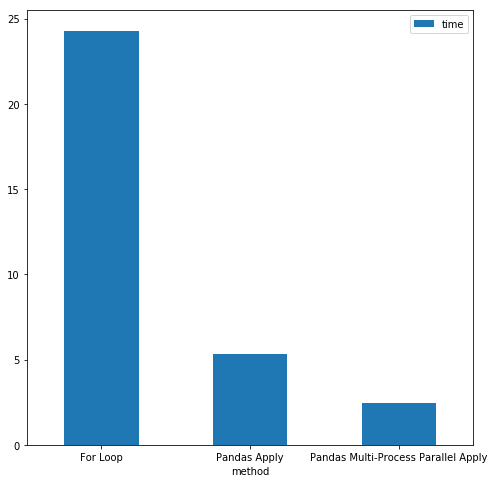

In [12]:
# 100K Sample
result_100K_df = pd.DataFrame([["For Loop", 24.3], 
                          ["Pandas Apply", 5.35],
                          ["Pandas Multi-Process Parallel Apply", 2.44]],
                         columns=["method", "time"])
result_100K_df.set_index("method")
print(result_100K_df)
result_100K_df.plot.bar(x="method", y="time", figsize=(8, 8), rot=False)

# Sample Size of 1M Rows

                                method   time
0                             For Loop  155.0
1                         Pandas Apply   45.3
2  Pandas Multi-Process Parallel Apply   28.9


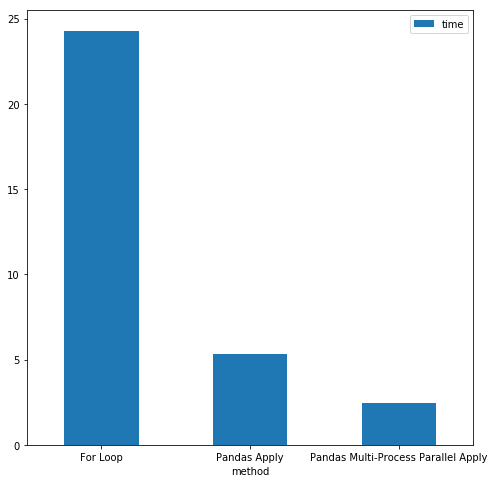

In [13]:
# 100K Sample
result_1M_df = pd.DataFrame([["For Loop", 155], 
                          ["Pandas Apply", 45.3],
                          ["Pandas Multi-Process Parallel Apply", 28.9]],
                         columns=["method", "time"])
result_1M_df.set_index("method")
print(result_1M_df)
result_100K_df.plot.bar(x="method", y="time", figsize=(8, 8), rot=False)

In [14]:
# Summary: The most basic for loop, looping row by row is really slow.
# 2.5 Minutes for an operation of 1M rolls.
# The Apply method when written properly, it is 4X faster.
# The Apply (Multi-Process Parallel) method is additonal 2X faster.
# My Macbook air only has 2s core running at 1.7Ghz.
# I would be really interested to see what will a 4 cores computer do!

# Conclusion: This is 4X faster, and which multiple by more many cores.
# Notice this is multiprocessing... not multithreading.